In [1]:
import numpy as np
from pathlib import Path

DATA_DIR = Path.cwd().parent / 'data'

sessions = np.array([])
for file in sorted(DATA_DIR.glob("steinmetz_part*.npz")):
    print(f"Loading {file}...")
    session = np.load(DATA_DIR / file, allow_pickle=True)
    sessions = np.hstack((sessions, session['dat']))

with open(DATA_DIR / "selectors.npy", "rb") as f:
    selectors = np.load(f, allow_pickle=True)

Loading /home/jovyan/work/data/steinmetz_part0.npz...
Loading /home/jovyan/work/data/steinmetz_part1.npz...
Loading /home/jovyan/work/data/steinmetz_part2.npz...


In [2]:
for i in range(len(sessions)):
    session = sessions[i]
    sel = selectors[i]
    neuron_count = sum(sel["NEURON_VISUAL"])
    if neuron_count == 0:
        continue
    stim_count = sum(~sel["STIM_RIGHT_NONE"])
    ratio = stim_count / neuron_count
    print(f"Session {i:2d} - {neuron_count:3d} neurons - {stim_count:3d} trials w/ stimulus - {ratio:2.2f} ratio")

Session  0 - 178 neurons - 128 trials w/ stimulus - 0.72 ratio
Session  1 - 533 neurons - 136 trials w/ stimulus - 0.26 ratio
Session  2 - 228 neurons - 119 trials w/ stimulus - 0.52 ratio
Session  3 -  39 neurons - 142 trials w/ stimulus - 3.64 ratio
Session  6 - 101 neurons - 133 trials w/ stimulus - 1.32 ratio
Session  7 -  89 neurons - 148 trials w/ stimulus - 1.66 ratio
Session  8 - 221 neurons - 179 trials w/ stimulus - 0.81 ratio
Session  9 - 204 neurons - 202 trials w/ stimulus - 0.99 ratio
Session 10 - 275 neurons - 169 trials w/ stimulus - 0.61 ratio
Session 11 - 145 neurons - 173 trials w/ stimulus - 1.19 ratio
Session 12 -  66 neurons - 162 trials w/ stimulus - 2.45 ratio
Session 13 -  79 neurons - 140 trials w/ stimulus - 1.77 ratio
Session 16 -  12 neurons - 134 trials w/ stimulus - 11.17 ratio
Session 17 - 158 neurons - 153 trials w/ stimulus - 0.97 ratio
Session 18 - 179 neurons - 130 trials w/ stimulus - 0.73 ratio
Session 19 - 122 neurons - 149 trials w/ stimulus - 1.

In [3]:
DECODER_SESSION = 10
SESSION = sessions[DECODER_SESSION]
SELECTOR = selectors[DECODER_SESSION]

CHOSEN_TRIALS = ~SELECTOR["STIM_RIGHT_NONE"]

CLASS_NAMES = ["Low", "Medium", "High"]
NUM_CLASSES = len(CLASS_NAMES)

In [4]:
num_no_stim = CHOSEN_TRIALS.sum() // 3
no_stim_trials = ~CHOSEN_TRIALS
cutoff_index = np.where(no_stim_trials.cumsum() > num_no_stim)[0][0]
no_stim_trials[cutoff_index:] = False

CHOSEN_TRIALS |= no_stim_trials
CLASS_NAMES.insert(0, "None")
NUM_CLASSES += 1

In [5]:
from scipy import signal

def get_spikes(session, neurons, trials, bins, align=50, baseline_bins=None, smoothing=None):
    bins = np.atleast_1d(align)[:, np.newaxis] + np.arange(*bins)
    bins += np.minimum(session['spks'].shape[2] - bins[:, -1] - 1, 0)[:, np.newaxis]
    bins -= np.minimum(bins[:, 0], 0)[:, np.newaxis]
    bins = bins[np.newaxis, :, :]

    if smoothing is not None:
        size = smoothing[0] // 2
        bins = np.concatenate(
            [
                bins[:, :, :size] - size,
                bins,
                bins[:, :, -size:] + size
            ],
            axis=2
        )
        bins += np.minimum(session['spks'].shape[2] - bins[:, :, -1] - 1, 0)[:, :, np.newaxis]
        bins -= np.minimum(bins[:, :, 0], 0)[:, :, np.newaxis]

    spikes = np.take_along_axis(session['spks'][neurons][:, trials], bins, 2)
    
    if baseline_bins is not None:
        start, end = baseline_bins
        baseline = session['spks'][neurons][:, trials][:, :, start:end]
        baseline = baseline.mean(axis=2)[:, :, np.newaxis]
        spikes = (spikes - baseline) / (baseline + 0.5)
        
    if smoothing is not None:
        size, std = smoothing
        half_gaussian = signal.gaussian(size, std)
        half_gaussian[size//2 + 1:] = 0
        spikes = signal.convolve(spikes, half_gaussian[np.newaxis, np.newaxis, :], mode='valid')
    
    return spikes

def reshape_by_bins(spikes):
    return spikes.transpose((1, 2, 0)).reshape(spikes.shape[1] * spikes.shape[2], spikes.shape[0])

# Confidence-based Classifier

In [6]:
from sklearn.preprocessing import LabelEncoder

spikes = get_spikes(
    SESSION,
    SELECTOR["NEURON_VISUAL"],
    CHOSEN_TRIALS,
    (0, 100),
    align=50,
    baseline_bins=None,
    smoothing=(17, 2.5),
)
NUM_BINS_TRAIN = spikes.shape[2]
NUM_BINS_FULL = spikes.shape[2]
classes = SESSION['contrast_right'][CHOSEN_TRIALS]

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(classes)

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
%matplotlib inline

trials = np.arange(spikes.shape[1])
skf = StratifiedKFold(n_splits=5)
y_pred = np.zeros((len(labels) * NUM_BINS_TRAIN))
scores = []
clf = LogisticRegression(penalty='l2', multi_class='ovr', solver='saga', max_iter=5000)
for train_index, val_index in skf.split(trials, labels):
    X_train = reshape_by_bins(spikes[:, train_index, -NUM_BINS_TRAIN:])
    X_val = reshape_by_bins(spikes[:, val_index, -NUM_BINS_TRAIN:])
    y_train = np.repeat(labels[train_index], NUM_BINS_TRAIN)
    y_val = np.repeat(labels[val_index], NUM_BINS_TRAIN)
    
    split_clf = LogisticRegression(**clf.get_params())
    split_clf.fit(X_train, y_train)
    split_pred = split_clf.predict(X_val)
    scores.append(np.mean(split_pred == y_val))
    y_pred[(val_index[:, np.newaxis] * NUM_BINS_TRAIN + np.arange(NUM_BINS_TRAIN)).flatten()] = split_pred

print(scores)
print(np.mean(scores))

[0.35044444444444445, 0.4464444444444444, 0.44377777777777777, 0.4697777777777778, 0.43222222222222223]
0.4285333333333333


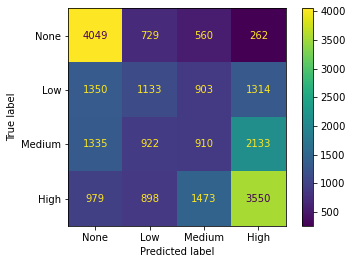

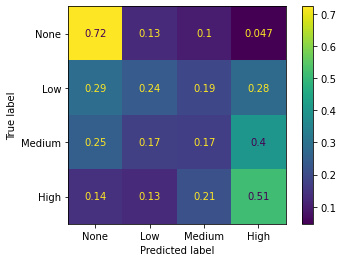

In [8]:
y = np.repeat(labels, NUM_BINS_TRAIN)
confusion = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=np.float32)
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        confusion[i, j] = np.sum((y == i) & (y_pred == j))

ConfusionMatrixDisplay(confusion.astype(np.int32), display_labels=CLASS_NAMES).plot()
confusion /= confusion.sum(axis=1, keepdims=True)
ConfusionMatrixDisplay(confusion, display_labels=CLASS_NAMES).plot()

In [9]:
X = reshape_by_bins(spikes)
NUM_BINS_FULL = X.shape[0] // sum(CHOSEN_TRIALS)
y = np.repeat(labels, NUM_BINS_FULL)
clf.fit(X, y)

LogisticRegression(max_iter=5000, multi_class='ovr', solver='saga')

In [10]:
CONFIDENCE_THRESHOLD = np.array([
    SELECTOR['CHOICE_CORRECT'][SELECTOR["STIM_RIGHT_LOW"]].mean(),
    SELECTOR['CHOICE_CORRECT'][SELECTOR["STIM_RIGHT_MEDIUM"]].mean(),
    SELECTOR['CHOICE_CORRECT'][SELECTOR["STIM_RIGHT_HIGH"]].mean(),
])

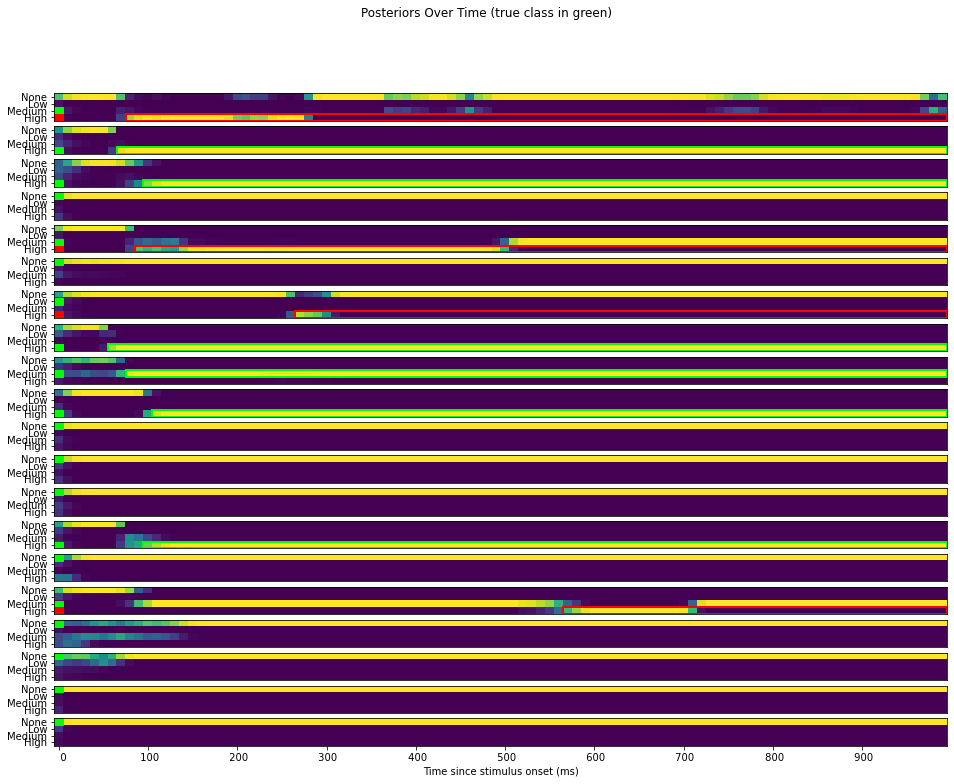

In [11]:
%matplotlib inline
plotted_trials = 20
xticks = np.arange(NUM_BINS_FULL // 10) * 10
xticklabels = [f"{i*10:4d}" for i in xticks]
fig, axes = plt.subplots(plotted_trials, 1, sharey=True)
fig.set_size_inches(16, 12)
fig.suptitle(f"Posteriors Over Time (true class in green)")

mouse_correct = SELECTOR["CHOICE_CORRECT"][CHOSEN_TRIALS].astype(int)
confusion_matrices = np.zeros((2, NUM_CLASSES, NUM_CLASSES), dtype=int)
decision_times = np.zeros(spikes.shape[1], dtype=int)
decisions = np.zeros_like(decision_times)
eps = np.finfo(float).eps

for trial_num in range(spikes.shape[1]):
    population_activity = X[(trial_num*NUM_BINS_FULL):((trial_num+1)*NUM_BINS_FULL), :]
    likelihoods = clf.predict_log_proba(population_activity)
    
    probs = np.zeros_like(likelihoods)
    probs[0] = likelihoods[0]
    for i in range(1, NUM_BINS_FULL):
        prob = np.exp(probs[i - 1] + likelihoods[i]) + eps
        probs[i] = np.log(prob / prob.sum())
    probs = np.exp(probs)
    
    decision = 0
    decided = np.argmax(probs[:, 1:] > CONFIDENCE_THRESHOLD, axis=0)
    if np.any(decided):
        decision = NUM_CLASSES - np.argmax(decided[::-1] > 0) - 1
        decision_times[trial_num] = decided[decision - 1]
        decisions[trial_num] = decision

    correct_class = labels[trial_num]
    confusion_matrices[mouse_correct[trial_num], correct_class, decision] += 1
    
    if trial_num >= plotted_trials:
        continue

    ax = axes[trial_num]
    im = ax.imshow(probs.T, vmin=0, vmax=1, aspect='auto')

    ax.axhspan(
        ymin=correct_class-0.5,
        ymax=correct_class+0.5,
        xmin=0,
        xmax=1/NUM_BINS_FULL,
        color=(0, 1, 0)
    )
    if decision > 0:
        ax.axhspan(
            ymin=decision-0.5,
            ymax=decision+0.5,
            xmin=decision_times[trial_num]/NUM_BINS_FULL,
            xmax=1,
            edgecolor='r' if decision != correct_class else (0,1,0),
            facecolor=(0, 0, 0, 0),
            lw=2,
        )
    if decision != correct_class:
        ax.axhspan(
            ymin=decision-0.5,
            ymax=decision+0.5,
            xmin=0,
            xmax=1/NUM_BINS_FULL,
            color='r'
        )
        
    ax.set_yticks(np.arange(NUM_CLASSES))
    ax.set_yticklabels(CLASS_NAMES)
    
    if trial_num != plotted_trials - 1:
        ax.set_xticks([])
        continue

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel("Time since stimulus onset (ms)")

plt.show()

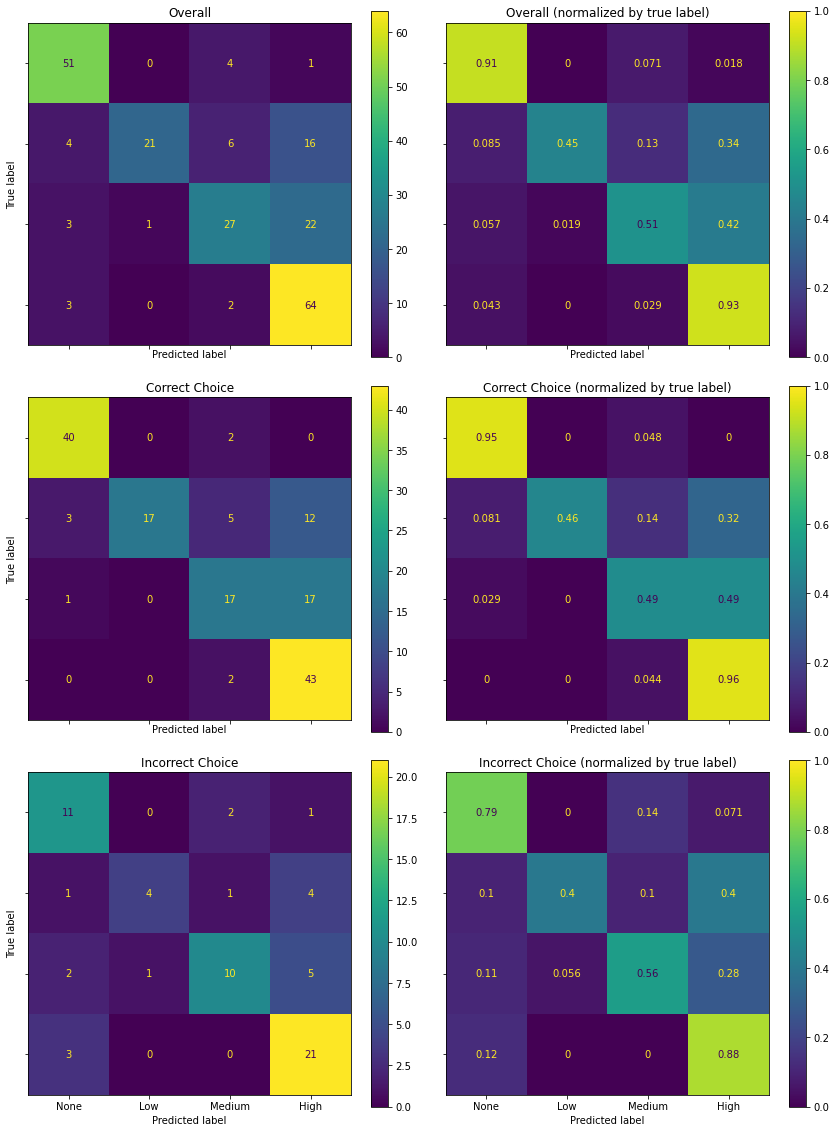

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay
%matplotlib inline

fig, axes = plt.subplots(3, 2, sharex=True, sharey=True)
fig.set_size_inches(12, 16)
fig.set_tight_layout(True)

data = [
    (confusion_matrices.sum(axis=0), "Overall"),
    (confusion_matrices[1], "Correct Choice"),
    (confusion_matrices[0], "Incorrect Choice"),
]
for i, (perf, title) in enumerate(data):
    axes[i, 0].set_title(title)
    ConfusionMatrixDisplay(perf, display_labels=CLASS_NAMES).plot(ax=axes[i, 0])
    
    ax = axes[i, 1]
    perf = perf / perf.sum(axis=1, keepdims=True)
    disp = ConfusionMatrixDisplay(perf, display_labels=CLASS_NAMES).plot(ax=ax)
    disp.im_.colorbar.remove()
    disp.im_ = ax.imshow(perf, vmin=0, vmax=1)
    fig.colorbar(disp.im_, ax=ax)
    ax.set_title(f"{title} (normalized by true label)")
    ax.set_ylabel("")
    ax.set_yticklabels([])

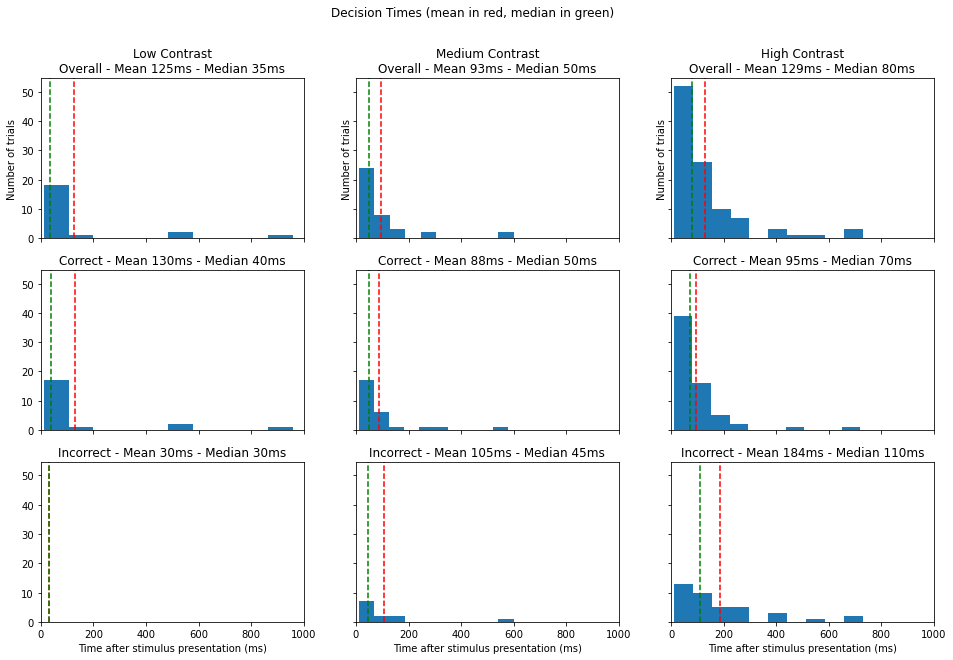

In [13]:
def plot_hist(ax, data, class_name):
    if len(data) == 0:
        return
    times = data * 10
    ax.hist(times)
    mean = times.mean()
    ax.axvline(x=mean, color='r', linestyle='--')
    median = np.median(times)
    ax.axvline(x=median, color='g', linestyle='--')
    ax.set_title(f'{class_name} - Mean {int(mean)}ms - Median {int(median)}ms')
    
fig, axes = plt.subplots(3, 3, sharey=True, sharex=True)
fig.set_size_inches(16, 10)
fig.suptitle("Decision Times (mean in red, median in green)")

for i, class_name in enumerate(CLASS_NAMES):
    if i == 0:
        continue
    ax = axes[:, i-1]
    decoder_classes = decisions == i
    true_classes = labels == i
    plot_hist(ax[0], decision_times[decoder_classes], f"{class_name} Contrast\nOverall")
    plot_hist(ax[1], decision_times[decoder_classes & true_classes], f"Correct")
    plot_hist(ax[2], decision_times[decoder_classes & ~true_classes], f"Incorrect")
    
    ax[0].set_ylabel('Number of trials')
    ax[-1].set_xlim([0, NUM_BINS_FULL*10])
    ax[-1].set_xlabel('Time after stimulus presentation (ms)')
    
fig.show()

In [14]:
from pathlib import Path
import pickle

results = {}
DECODER_RESULTS = DATA_DIR / 'decoder_results.pickle'
if DECODER_RESULTS.exists():
    with open(DECODER_RESULTS, 'rb') as f:
        results = pickle.load(f)

if DECODER_SESSION not in results:
    results[DECODER_SESSION] = {}

results[DECODER_SESSION]['vision'] = {
    'trial_numbers': np.where(CHOSEN_TRIALS)[0],
    'decision_times': decision_times * 10,
    'decisions': np.array(CLASS_NAMES)[decisions],
    'decoder': clf,
}

with open(DECODER_RESULTS, 'wb') as f:
    pickle.dump(results, f)

# Histogram-based Classifier

In [15]:
from sklearn.model_selection import cross_val_score

X_hist = get_spikes(
    SESSION,
    SELECTOR["NEURON_VISUAL"],
    CHOSEN_TRIALS,
    (0, 50),
    align=50,
    baseline_bins=None,
    smoothing=(17, 2.5),
)
X_hist = X_hist.sum(axis=2).T
y_hist = labels

hist_clf = LogisticRegression(penalty='l2', multi_class='ovr', solver='saga', max_iter=10000)
scores = cross_val_score(hist_clf, X_hist, y_hist, cv=5, n_jobs=-1)
print(scores)
print(scores.mean())

[0.48888889 0.53333333 0.42222222 0.55555556 0.42222222]
0.4844444444444444


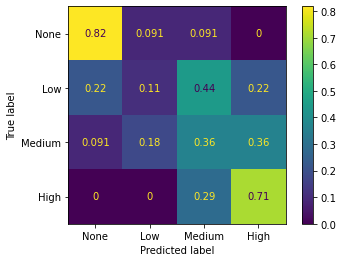

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
%matplotlib inline

X_train, X_test, y_train, y_test = train_test_split(
    X_hist,
    y_hist,
    test_size=0.2,
    shuffle=True,
    stratify=y_hist
)
hist_clf.fit(X_train, y_train)
plot_confusion_matrix(hist_clf, X_test, y_test, display_labels=CLASS_NAMES, normalize='true')

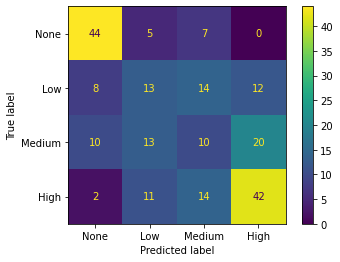

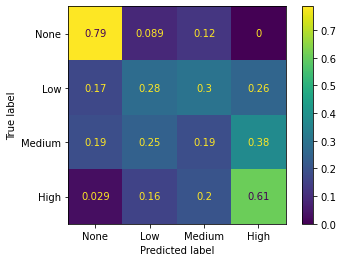

In [17]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import plot_confusion_matrix
%matplotlib inline

y_pred = cross_val_predict(hist_clf, X_hist, y_hist, cv=5, n_jobs=-1)
perf = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=int)
for i in range(len(y_pred)):
    perf[y_hist[i], y_pred[i]] += 1
    
ConfusionMatrixDisplay(perf, display_labels=CLASS_NAMES).plot()
ConfusionMatrixDisplay(perf / perf.sum(axis=1, keepdims=True), display_labels=CLASS_NAMES).plot()

# LDA Classifier

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X_lda = get_spikes(
    SESSION,
    SELECTOR["NEURON_VISUAL"],
    SELECTOR["CHOICE_CORRECT"],
    (0, 50),
    align=50,
    baseline_bins=None,
    smoothing=None,
)
NUM_BINS_LDA = X_lda.shape[2]
X_lda = reshape_by_bins(X_lda)
y_lda = label_encoder.transform(np.repeat(SESSION['contrast_right'][SELECTOR["CHOICE_CORRECT"]], NUM_BINS_LDA))

lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto', n_components=3)
lda.fit(X_lda, y_lda)
print(lda.explained_variance_ratio_)

[0.03288875 0.03288868 0.03288868]


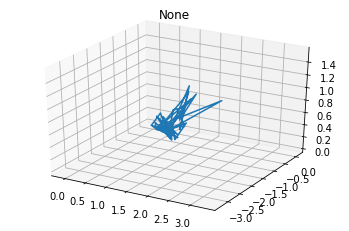

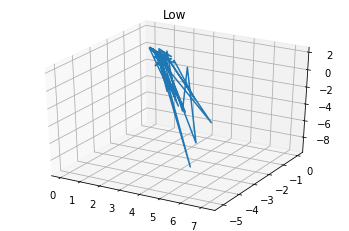

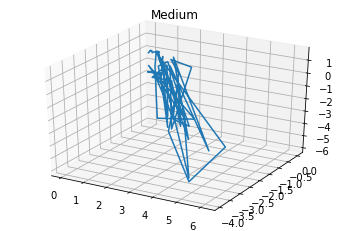

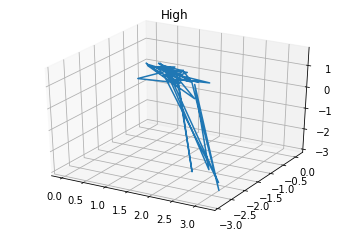

In [19]:
%matplotlib inline

for i, class_name in enumerate(CLASS_NAMES):
    trial_num = np.argmax(classes == label_encoder.inverse_transform([i])[0])
    transformed = lda.transform(X_lda[trial_num*NUM_BINS_LDA:(trial_num+1)*NUM_BINS_LDA])

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(transformed[:, 0], transformed[:, 1], transformed[:, 2])
    ax.set_title(class_name)

# Contrast-level Linear Regressor

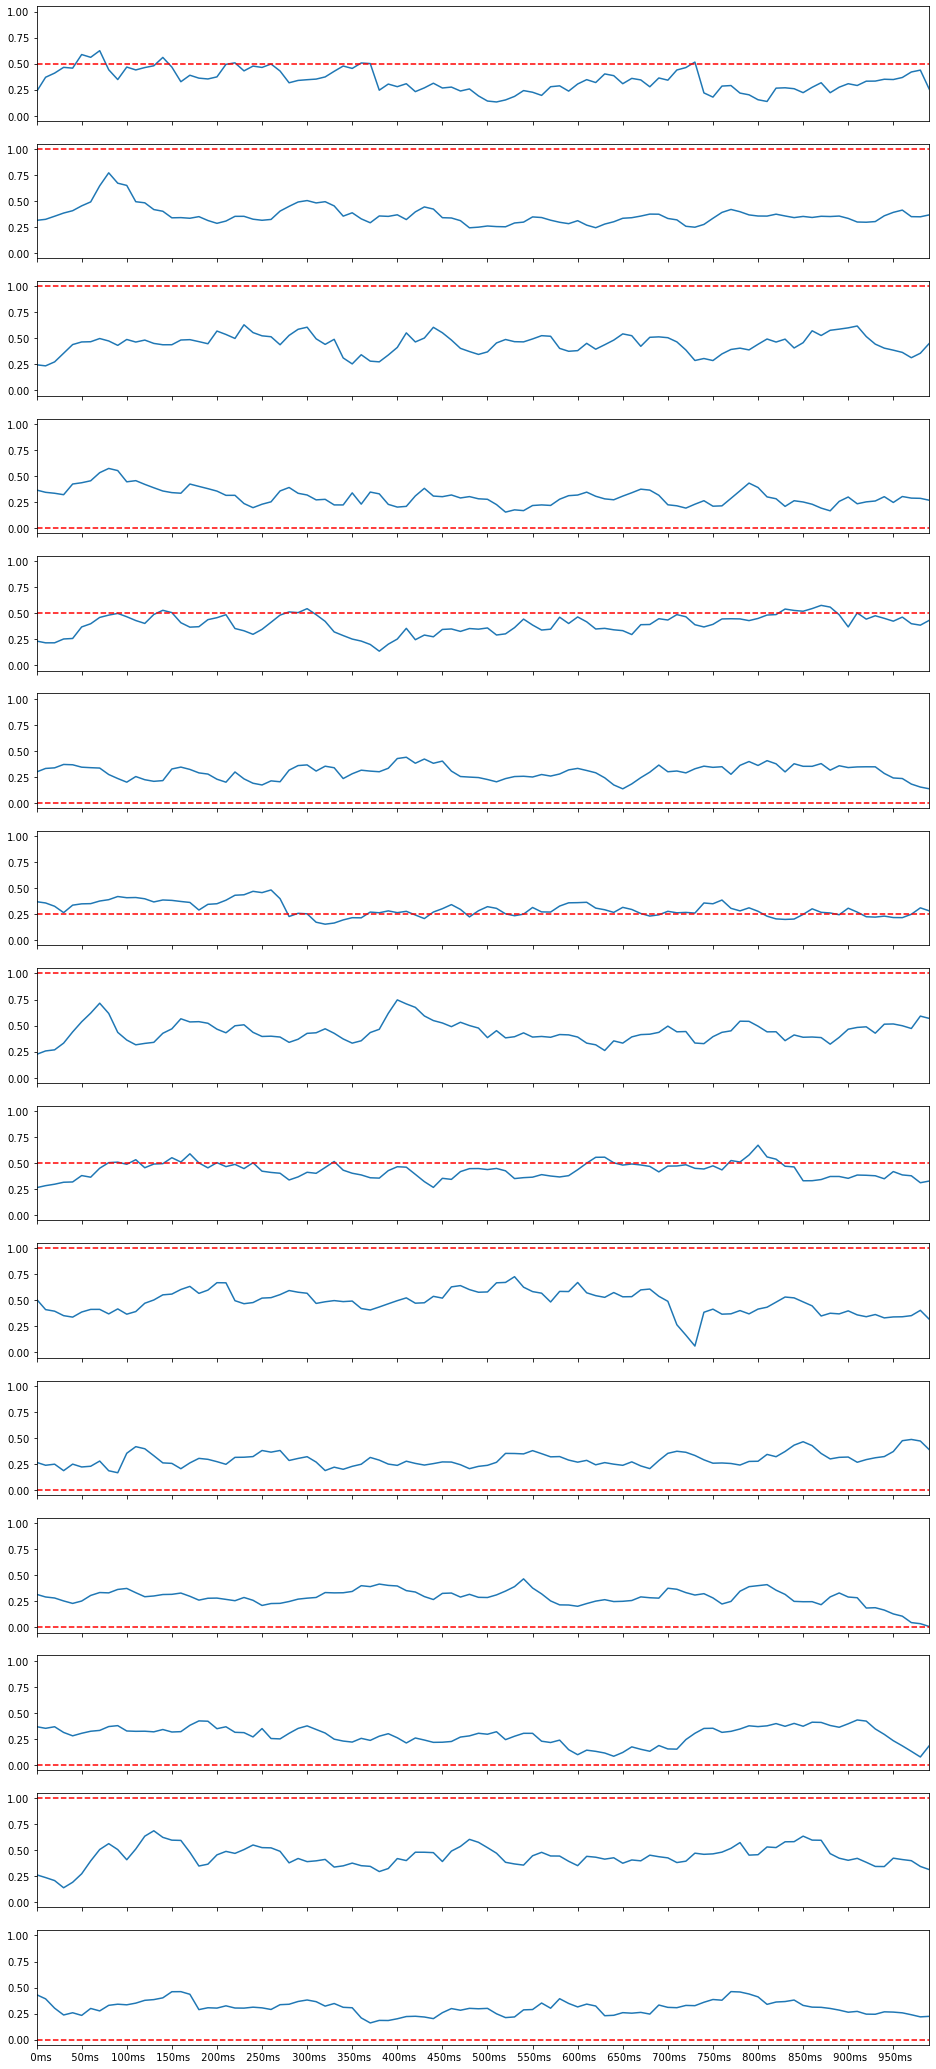

In [20]:
from sklearn.linear_model import Ridge
%matplotlib inline

X_reg = get_spikes(
    SESSION,
    SELECTOR["NEURON_VISUAL"],
    CHOSEN_TRIALS,
    (0, 100),
    align=50,
    baseline_bins=(30,50),
    smoothing=(17, 2.5),
)
NUM_BINS_REG = X_reg.shape[2]
y_reg = np.repeat(classes, NUM_BINS_REG)
X_reg = reshape_by_bins(X_reg)

reg = Ridge()
reg.fit(X_reg, y_reg)

plotted_trials = 15
xticks = np.arange(NUM_BINS_REG // 5) * 5
xticklabels = [f"{i*10:4d}ms" for i in xticks]
fig, axes = plt.subplots(plotted_trials, 1, sharex=True)
fig.set_size_inches(16, 2.5 * plotted_trials)

for trial_num in range(plotted_trials):
    y_true = classes[trial_num]
    population_activity = X[(trial_num*NUM_BINS_REG):((trial_num+1)*NUM_BINS_REG), :]
    y_pred = reg.predict(population_activity)
    
    ax = axes[trial_num]
    ax.plot(y_pred)
    ax.set_ylim([-0.05, 1.05])
    ax.axhline(y=y_true, color='r', linestyle='--')
    
    if trial_num != plotted_trials - 1:
        continue

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlim([0, NUM_BINS_REG - 1])

plt.show()